In [1]:
!pip install neuralprophet

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
from neuralprophet import NeuralProphet

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os


*   load data for all the sites before 2024_08_21.
*   Filter the dataset to get only the past alarms of Site ID = PU0009

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Path of folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/2024_08_21/'

# Get list of all CSV files in the folder
csv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize an empty list to hold the dataframes
dfs = []

# Loop through the CSV files and read each one into a dataframe
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
data = pd.concat(dfs, ignore_index=True)

Mounted at /content/drive




*   Filter only the columns needed

In [5]:
data_selected = data[['Alarm Name', 'Alarm Location Info', 'First Occurred On', 'Site ID', 'Vendor', 'Domain', 'Device Type']]
data_selected.head(10)

,Alarm Name,Alarm Location Info,First Occurred On,Site ID,Vendor,Domain,Device Type
0,Rectifier Failure Alarm,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-21 15:47:29,AM0247,HUAWEI,Power,NaN
1,S1 Interface Fault,"eNodeB Function Name=Mahabage-GM0032-L, S1 Int...",2024-08-21 15:47:05,GM0032,HUAWEI,Access,eNodeB
2,S1 Interface Fault,"eNodeB Function Name=Mahabage-GM0032-L, S1 Int...",2024-08-21 15:47:05,GM0032,HUAWEI,Access,eNodeB
3,S1 Interface Fault,"eNodeB Function Name=Mahabage-GM0032-L, S1 Int...",2024-08-21 15:47:05,GM0032,HUAWEI,Access,eNodeB
4,Mains Failure Alarm,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-21 15:46:33,TR0076,HUAWEI,Power,GBTS
5,S1ap Link Down,"Mobile Country Code=413, Mobile Network Code=0...",2024-08-21 15:45:59,NaN,HUAWEI,Others,NaN
6,Theft Alarm,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-21 15:45:50,PU0146,HUAWEI,Power,eGBTS
7,Mains Failure Alarm,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-21 15:45:32,MU0025,HUAWEI,Power,eGBTS
8,Burglar Alarm,"Cabinet No.=0, Subrack No.=7, Slot No.=0, Boar...",2024-08-21 15:45:29,JA0018,HUAWEI,Power,NaN
9,IPPM session fault,"Local IP address=172.27.24.251, VPN=VPN_S1, Pe...",2024-08-21 15:45:23,VV0000,HUAWEI,Core,Unknown


In [6]:
# prompt: get only alarms for site id PU0146

PU0146_alarms = data_selected[data_selected['Site ID'] == 'PU0009']
PU0146_alarms.head(10)



,Alarm Name,Alarm Location Info,First Occurred On,Site ID,Vendor,Domain,Device Type
1279,RF Unit TX Channel Gain Out of Range,"Cabinet No.=0, Subrack No.=131, Slot No.=0, TX...",2024-08-21 14:40:10,PU0009,HUAWEI,Access,GBTS
25249,RF Unit TX Channel Gain Out of Range,"Cabinet No.=0, Subrack No.=131, Slot No.=0, TX...",2024-08-20 18:01:33,PU0009,HUAWEI,Access,GBTS
26418,Cell Unavailable,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:13:43,PU0009,HUAWEI,Access,eNodeB
26419,Cell Unavailable,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:13:43,PU0009,HUAWEI,Access,eNodeB
26421,RF Unit Maintenance Link Failure,"Cabinet No.=0, Subrack No.=61, Slot No.=0, Boa...",2024-08-20 17:12:23,PU0009,HUAWEI,Access,eNodeB
26423,RF Unit Maintenance Link Failure,"Cabinet No.=0, Subrack No.=61, Slot No.=0, Boa...",2024-08-20 17:13:39,PU0009,HUAWEI,Access,eNodeB
26468,Cell Unavailable,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:12:25,PU0009,HUAWEI,Access,eNodeB
26469,Cell Unavailable,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:12:25,PU0009,HUAWEI,Access,eNodeB
31496,Cell Unavailable,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 14:13:58,PU0009,HUAWEI,Access,eNodeB
31511,Cell Unavailable,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 14:13:49,PU0009,HUAWEI,Access,eNodeB


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Alarm Name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Alarm Location Info').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('First Occurred On').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Device Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Alarm Location Info'].value_counts()
    for x_label, grp in _df_4.groupby('Alarm Name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Alarm Name')
_ = plt.ylabel('Alarm Location Info')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['First Occurred On'].value_counts()
    for x_label, grp in _df_5.groupby('Alarm Location Info')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Alarm Location Info')
_ = plt.ylabel('First Occurred On')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Device Type'].value_counts()
    for x_label, grp in _df_6.groupby('First Occurred On')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('First Occurred On')
_ = plt.ylabel('Device Type')

In [7]:
# prompt: encode the Alarm name column  and rename that column as y

le = LabelEncoder()
PU0146_alarms['y'] = le.fit_transform(PU0146_alarms['Alarm Name'])
PU0146_alarms = PU0146_alarms.drop('Alarm Name', axis=1)
PU0146_alarms.head(10)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-7-d030e3972aa3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PU0146_alarms['y'] = le.fit_transform(PU0146_alarms['Alarm Name'])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PU0146_alarms['y'] = le.fit_transform(PU0146_alarms['Alarm Name'])



,Alarm Location Info,First Occurred On,Site ID,Vendor,Domain,Device Type,y
1279,"Cabinet No.=0, Subrack No.=131, Slot No.=0, TX...",2024-08-21 14:40:10,PU0009,HUAWEI,Access,GBTS,13
25249,"Cabinet No.=0, Subrack No.=131, Slot No.=0, TX...",2024-08-20 18:01:33,PU0009,HUAWEI,Access,GBTS,13
26418,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:13:43,PU0009,HUAWEI,Access,eNodeB,1
26419,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:13:43,PU0009,HUAWEI,Access,eNodeB,1
26421,"Cabinet No.=0, Subrack No.=61, Slot No.=0, Boa...",2024-08-20 17:12:23,PU0009,HUAWEI,Access,eNodeB,12
26423,"Cabinet No.=0, Subrack No.=61, Slot No.=0, Boa...",2024-08-20 17:13:39,PU0009,HUAWEI,Access,eNodeB,12
26468,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:12:25,PU0009,HUAWEI,Access,eNodeB,1
26469,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:12:25,PU0009,HUAWEI,Access,eNodeB,1
31496,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 14:13:58,PU0009,HUAWEI,Access,eNodeB,1
31511,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 14:13:49,PU0009,HUAWEI,Access,eNodeB,1


In [8]:
# prompt: give mapping of encoded value to alarm name  print line by line

for i, alarm_name in enumerate(le.classes_):
  print(f'{i}: {alarm_name}')

0: Cell Out of Service
1: Cell Unavailable
2: Data Configuration Exceeding Licensed Limit
3: Fuse Failure Alarm
4: GSM Local Cell Unusable
5: Generator On Load Alarm
6: IP PM Activation Failure
7: IP Path Fault
8: Licensed Feature Unusable
9: Mains Failure Alarm
10: NE Is Disconnected
11: RF Unit External Power Supply Insufficient
12: RF Unit Maintenance Link Failure
13: RF Unit TX Channel Gain Out of Range
14: RF Unit VSWR Threshold Crossed
15: Remote Maintenance Link Failure
16: S1 Interface Fault
17: SCTP Link Congestion
18: SCTP Link Fault
19: User Plane Path Fault


In [9]:
# prompt: rename first occured column as ds

PU0146_alarms = PU0146_alarms.rename(columns={'First Occurred On': 'ds'})
PU0146_alarms.head(10)


,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
1279,"Cabinet No.=0, Subrack No.=131, Slot No.=0, TX...",2024-08-21 14:40:10,PU0009,HUAWEI,Access,GBTS,13
25249,"Cabinet No.=0, Subrack No.=131, Slot No.=0, TX...",2024-08-20 18:01:33,PU0009,HUAWEI,Access,GBTS,13
26418,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:13:43,PU0009,HUAWEI,Access,eNodeB,1
26419,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:13:43,PU0009,HUAWEI,Access,eNodeB,1
26421,"Cabinet No.=0, Subrack No.=61, Slot No.=0, Boa...",2024-08-20 17:12:23,PU0009,HUAWEI,Access,eNodeB,12
26423,"Cabinet No.=0, Subrack No.=61, Slot No.=0, Boa...",2024-08-20 17:13:39,PU0009,HUAWEI,Access,eNodeB,12
26468,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:12:25,PU0009,HUAWEI,Access,eNodeB,1
26469,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:12:25,PU0009,HUAWEI,Access,eNodeB,1
31496,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 14:13:58,PU0009,HUAWEI,Access,eNodeB,1
31511,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 14:13:49,PU0009,HUAWEI,Access,eNodeB,1


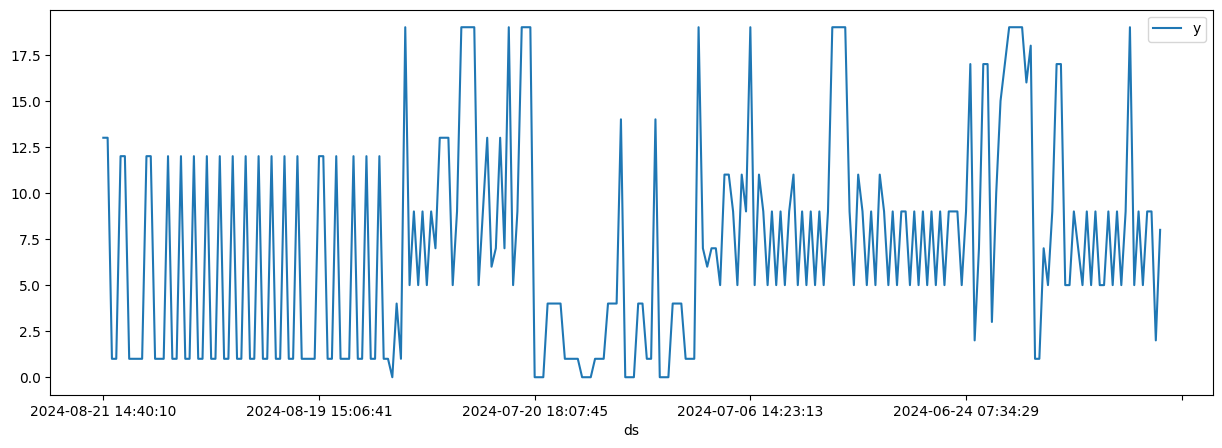

In [10]:
import pandas as pd

# Load the dataset from the CSV file using pandas
# df = pd.read_csv("https://github.com/ourownstory/neuralprophet-data/raw/main/kaggle-energy/datasets/tutorial01.csv")
# Plot the dataset, showing price (y column) over time (ds column)
plt = PU0146_alarms.plot(x="ds", y="y", figsize=(15, 5))

In [11]:
# prompt: sort accoding to ds column latest alarms

PU0146_alarms['ds'] = pd.to_datetime(PU0146_alarms['ds'])
PU0146_alarms = PU0146_alarms.sort_values(by='ds', ascending=False)
PU0146_alarms.head(10)


,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
1279,"Cabinet No.=0, Subrack No.=131, Slot No.=0, TX...",2024-08-21 14:40:10,PU0009,HUAWEI,Access,GBTS,13
25249,"Cabinet No.=0, Subrack No.=131, Slot No.=0, TX...",2024-08-20 18:01:33,PU0009,HUAWEI,Access,GBTS,13
26418,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:13:43,PU0009,HUAWEI,Access,eNodeB,1
26419,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:13:43,PU0009,HUAWEI,Access,eNodeB,1
26423,"Cabinet No.=0, Subrack No.=61, Slot No.=0, Boa...",2024-08-20 17:13:39,PU0009,HUAWEI,Access,eNodeB,12
26468,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:12:25,PU0009,HUAWEI,Access,eNodeB,1
26469,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:12:25,PU0009,HUAWEI,Access,eNodeB,1
26421,"Cabinet No.=0, Subrack No.=61, Slot No.=0, Boa...",2024-08-20 17:12:23,PU0009,HUAWEI,Access,eNodeB,12
31496,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 14:13:58,PU0009,HUAWEI,Access,eNodeB,1
31511,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 14:13:49,PU0009,HUAWEI,Access,eNodeB,1


In [12]:
# prompt: drop rows with y is unknown

PU0146_alarms = PU0146_alarms[PU0146_alarms['y'] != 'Unknown']

In [13]:
# prompt: remove duplicates in ds

PU0146_alarms = PU0146_alarms.drop_duplicates(subset=['ds'])
PU0146_alarms.head(10)


,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
1279,"Cabinet No.=0, Subrack No.=131, Slot No.=0, TX...",2024-08-21 14:40:10,PU0009,HUAWEI,Access,GBTS,13
25249,"Cabinet No.=0, Subrack No.=131, Slot No.=0, TX...",2024-08-20 18:01:33,PU0009,HUAWEI,Access,GBTS,13
26418,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:13:43,PU0009,HUAWEI,Access,eNodeB,1
26423,"Cabinet No.=0, Subrack No.=61, Slot No.=0, Boa...",2024-08-20 17:13:39,PU0009,HUAWEI,Access,eNodeB,12
26468,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 17:12:25,PU0009,HUAWEI,Access,eNodeB,1
26421,"Cabinet No.=0, Subrack No.=61, Slot No.=0, Boa...",2024-08-20 17:12:23,PU0009,HUAWEI,Access,eNodeB,12
31496,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 14:13:58,PU0009,HUAWEI,Access,eNodeB,1
31511,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 14:13:49,PU0009,HUAWEI,Access,eNodeB,1
31513,"Cabinet No.=0, Subrack No.=61, Slot No.=0, Boa...",2024-08-20 14:13:46,PU0009,HUAWEI,Access,eNodeB,12
31525,"eNodeB Function Name=Marawila-PU0009-L, Local ...",2024-08-20 14:12:25,PU0009,HUAWEI,Access,eNodeB,1


In [14]:
# prompt: keep only ds and y columns

PU0146_alarms = PU0146_alarms[['ds', 'y']]
PU0146_alarms.head(10)


,ds,y
1279,2024-08-21 14:40:10,13
25249,2024-08-20 18:01:33,13
26418,2024-08-20 17:13:43,1
26423,2024-08-20 17:13:39,12
26468,2024-08-20 17:12:25,1
26421,2024-08-20 17:12:23,12
31496,2024-08-20 14:13:58,1
31511,2024-08-20 14:13:49,1
31513,2024-08-20 14:13:46,12
31525,2024-08-20 14:12:25,1


In [15]:

# Import the NeuralProphet class
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

PU0146_alarms['ds'] = pd.to_datetime(PU0146_alarms['ds'])  # Ensure 'ds' is datetime
PU0146_alarms = PU0146_alarms.set_index('ds').resample('H').mean().reset_index()

# Create a NeuralProphet model with default parameters
# Set the learning rate and define other hyperparameters directly
m = NeuralProphet(
    learning_rate=0.005,          # Set the learning rate to 0.005
               # Sparsity in auto-regression (tune as needed)
    seasonality_mode='additive',  # Seasonality mode (choose between 'additive' or 'multiplicative')
)

# Use static plotly in notebooks
m.set_plotting_backend("plotly-static")

# Fit the model on the dataset (this might take a bit)
metrics = m.fit(PU0146_alarms)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Predicting: |          | 0/? [00:00<?, ?it/s]

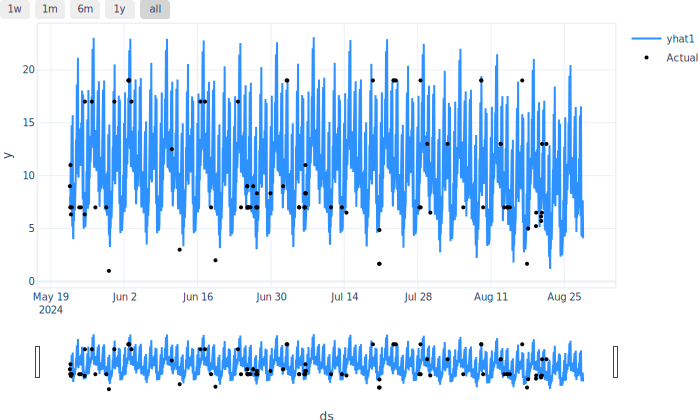

In [16]:
# Create a new dataframe reaching 24*7 into the future for our forecast, n_historic_predictions also shows historic data
df_future = m.make_future_dataframe(PU0146_alarms, n_historic_predictions=True, periods=24*7)

# Predict the future
forecast = m.predict(df_future)

# Visualize the forecast
m.plot(forecast)

In [17]:
# Create a new dataframe reaching 7 days into the future for our forecast
df_future = m.make_future_dataframe(PU0146_alarms, n_historic_predictions=True, periods=24*7)

# Predict the future
forecast = m.predict(df_future)

# Limit to 2 or 3 alarms per day
forecast['date'] = forecast['ds'].dt.date  # Extract the date from the datetime
daily_predictions = forecast.groupby('date').apply(lambda x: x.nlargest(2, 'yhat1')).reset_index(drop=True)

# Plot 'yhat1' as dots on top of the existing plot
plt.figure(figsize=(55, 25))  # Create a new figure with adjusted size
plt.scatter(daily_predictions['ds'], daily_predictions['yhat1'], color='red', label='yhat1 forecast')

# Add labels to data points
for i, row in daily_predictions.iterrows():
    plt.text(row['ds'], row['yhat1'], f'{row["yhat1"]:.2f}', fontsize=9, ha='right', va='bottom')

plt.xlabel('Date')
plt.ylabel('yhat1')
plt.title('Top 2 or 3 Alarms per Day')
plt.legend()
plt.grid(True)  # Add grid lines for better readability

# Set x-axis ticks to show all dates
plt.xticks(daily_predictions['ds'], rotation=45, ha='right')

# Set y-axis ticks to show all yhat1 values
plt.yticks(daily_predictions['yhat1'])

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot


Predicting: |          | 0/? [00:00<?, ?it/s]

TypeError: 'Figure' object is not callable

In [ ]:
# prompt: print the forecast alarms around value 13  with the date, print only the data after the latest day of initial data

# Filter forecast for alarms around value 13
filtered_forecast = forecast[(forecast['yhat1'] >= 12.8) & (forecast['yhat1'] <= 13.3)]

# Get the latest date in the original data
last_date = PU0146_alarms['ds'].max()

# Filter for dates after the last date in the original data
filtered_forecast = filtered_forecast[filtered_forecast['ds'] > last_date]

# Print the filtered forecast with date and yhat1
for index, row in filtered_forecast.iterrows():
  print(f"Date: {row['ds']}, Alarm (yhat1): {row['yhat1']:.2f}")


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Limit to 2 or 3 alarms per day
forecast['date'] = forecast['ds'].dt.date  # Extract the date from the datetime
daily_predictions = forecast.groupby('date').apply(lambda x: x.nlargest(3, 'yhat1')).reset_index(drop=True)

# Create a new figure with adjusted size
fig, ax = plt.subplots(figsize=(55, 25))

# Plot 'yhat1' as dots on top of the existing plot
ax.scatter(daily_predictions['ds'], daily_predictions['yhat1'], color='red', label='yhat1 forecast')

# Add labels to data points
for i, row in daily_predictions.iterrows():
    ax.text(row['ds'], row['yhat1'], f'{row["yhat1"]:.2f}', fontsize=9, ha='right', va='bottom')

ax.set_xlabel('Date')
ax.set_ylabel('yhat1')
ax.set_title('Top 2 or 3 Alarms per Day')
ax.legend()
ax.grid(True)  # Add grid lines for better readability

# Set x-axis ticks to show all dates
plt.xticks(daily_predictions['ds'], rotation=45, ha='right')

# Set y-axis ticks to show all yhat1 values
plt.yticks(daily_predictions['yhat1'])

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot

In [ ]:
# prompt: print the forecast data after the last day of actual data points  points with the date

# Find the last date in the original data
last_date = PU0146_alarms['ds'].max()

# Filter the forecast data to include only dates after the last date
forecast_future = forecast[forecast['ds'] > last_date]

# Print the forecast data with the date
for index, row in forecast_future.iterrows():
  print(f"Date: {row['ds'].date()}, yhat1: {row['yhat1']:.2f}")


In [ ]:
# Ensure that the forecast data and figure are valid before proceeding
if forecast is not None:
    # Extract the necessary columns for plotting
    ds_dates = forecast['ds']  # Time points
    yhat_values = forecast['yhat1']  # Forecasted values

    # Create a dot plot using plotly
    dot_plot = go.Figure(data=go.Scatter(
        x=ds_dates,
        y=yhat_values,
        mode='markers',  # Use 'markers' mode for dots
        marker=dict(color='blue', size=2),  # Customize the dot color and size
        name='Forecasted Values'
    ))

    # Customize the layout of the plot
    dot_plot.update_layout(
        title='Forecasted Values as Dot Plot',
        xaxis_title='Date',
        yaxis_title='Forecasted Value',
        height=500,
        width=1000,
    )

    # Show the plot
    dot_plot.show()
else:
    print("Warning: Forecast data is not available for plotting.")